# Lab 6: Significance is not enough

Introduction to Data Science (DS-GA1001)

Code by: Stephen Spivack (ss7726@nyu.edu), Pascal Wallisch (pascalwallisch@nyu.edu)

Date: 10-12-23

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## 1) Mean differences, effect sizes and significance

### Effect sizes as salvation? take home message: The same effect size can correspond to dramatically different p values.


Initialize variables

In [3]:
numReps = 500 # Number of repetitions in our simulation
sata = np.empty([numReps,3,2]) # Initialize empty 3D array for sata
sata[:] = np.NaN # then convert to NaN 
PvsE = np.empty([numReps,5]) # Initialize empty 2D array for PvsE
PvsE[:] = np.NaN # then convert to NaN

Generate and analyze sata

In [4]:
for ii in range(numReps): # loop through each rep
    p = 0 # set p to 0
    while abs(p - 0.04) > 0.01: # Find datasets that are just about significant
        # main idea: all the p-vals will be just under 0.05 - but we will see differences, for instance in cohen's d
        temp = np.random.normal(0,1,[3,2]) # Draw n = 3 (mu = 0, sigma = 1)
        t,p = stats.ttest_rel(temp[:,0],temp[:,1]) # paired t-test
    sata[ii] = temp # store temp in sata array
    
    # sample size:
    PvsE[ii,0] = len(sata[ii,:,:]) # take the length of the z-stack dimension
    
    # significance level:
    t,p = stats.ttest_rel(sata[ii,:,0],sata[ii,:,1]) # paired t-test
    PvsE[ii,1] = p 
    
    # effect size (computing cohen's d by hand):
    mean1 = np.mean(sata[ii,:,0]) # mean of sample 1
    mean2 = np.mean(sata[ii,:,1]) # mean of sample 2
    std1 = np.std(sata[ii,:,0]) # std of sample 1
    std2 = np.std(sata[ii,:,1]) # std of sample 2
    n1 = len(sata[ii,:,0]) # size of sample 1
    n2 = len(sata[ii,:,1]) # size of sample 2
    numerator = abs(mean1-mean2) # absolute value of mean difference
    denominator = np.sqrt((std1**2)/2 + (std2**2)/2) # pooled std
    d = numerator/denominator
    PvsE[ii,2] = d
    
    # mean differences:
    PvsE[ii,3] = abs(np.mean(sata[ii,:,0]) - np.mean(sata[ii,:,1]))
    
    # pooled standard deviation:
    PvsE[ii,4] = np.sqrt((std1**2)/2 + (std2**2)/2)

Plot it

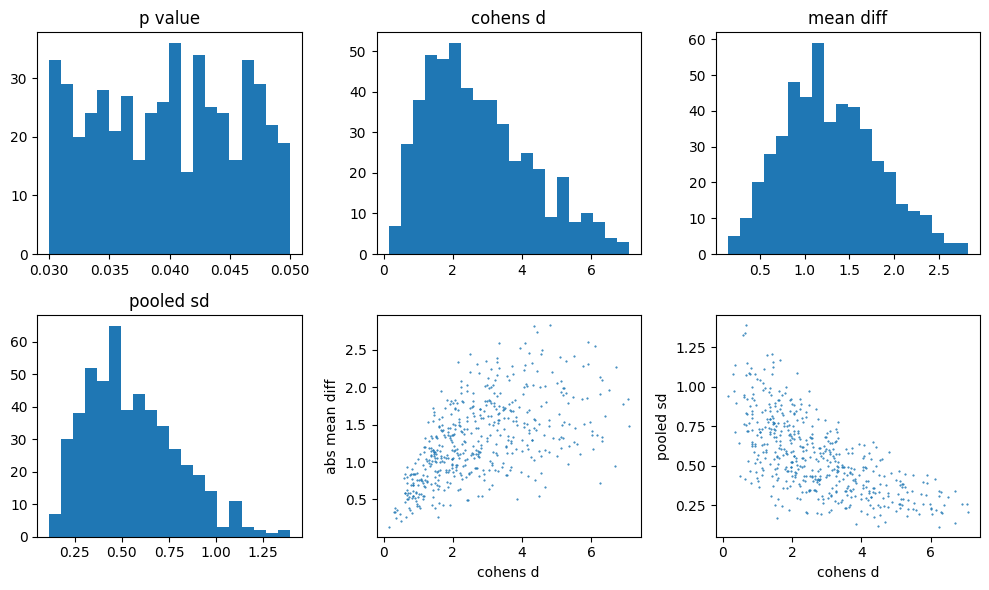

In [5]:
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.hist(PvsE[:,1],20)
plt.title('p value')
plt.subplot(2,3,2)
plt.hist(PvsE[:,2],20)
plt.title('cohens d')
plt.subplot(2,3,3)
plt.hist(PvsE[:,3],20)
plt.title('mean diff')
plt.subplot(2,3,4)
plt.hist(PvsE[:,4],20)
plt.title('pooled sd')
plt.subplot(2,3,5)
plt.plot(PvsE[:,2],PvsE[:,3],'o',markersize=.5)
plt.xlabel('cohens d')
plt.ylabel('abs mean diff')
plt.subplot(2,3,6)
plt.plot(PvsE[:,2],PvsE[:,4],'o',markersize=.5)
plt.xlabel('cohens d')
plt.ylabel('pooled sd')
plt.tight_layout()
plt.show()

## 2) Distributions of p values assuming true vs. false null hypothesis (H0)

Initialize variables

In [ ]:
sampleSize = 100
numReps = int(1e4) # Number of repetitions in our simulation
meanDifference = 0.25 # Actual difference in sample means. Try 0 and other values.
alpha = 0.05 #The alpha level

Generate some sata and run the t-test

In [ ]:
# Draw from a random normal distribution with zero mean:
sata1 = np.random.normal(0,1,[sampleSize,numReps])

# Our 2nd sample. Same distribution, different mean:
sata2 = np.random.normal(0,1,[sampleSize,numReps]) + meanDifference

# Run a t-test, a lot of times:
t = np.empty([numReps,1]) # initialize empty 2D array for t
t[:] = np.NaN # then convert to NaN
p = np.empty([numReps,1]) # initialize empty 2D array for p
p[:] = np.NaN # then convert to NaN
for ii in range(numReps): # loop through each rep
    t[ii],p[ii] = stats.ttest_ind(sata1[:,ii],sata2[:,ii]) # do the t-test

Plot it

In [ ]:
plt.hist(p,100)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.show()

Determine proportion significant results:

In [ ]:
Q = len(np.argwhere(p<alpha).flatten())/len(p)
print('Proportion significant results:',Q)

## 3) The powerscape - generalizing effect sizes and sample sizes

Initialize variables

In [ ]:
popSize = int(1e3) # Size of the population
nnMax = 250 # Maximal sample size to be considered
nnMin = 5 # Minimal sample size to be considered
sampleSize = np.linspace(nnMin,nnMax,246) # array of each sample size
effectSize = np.linspace(0,1.5,31) # From 0 to 1.5, in .05 increments
# As std is one, effect_size will be in units of std
pwr = np.empty([len(sampleSize),len(effectSize)]) # initialize power array
pwr[:] = np.NaN # then conver to nan

Run simulation

In [ ]:
for es in range(len(effectSize)): # loop through each effect size (31 total)
    A = np.random.normal(0,1,[popSize,2]) # Get the population of random 
    # numbers for each effect size - 2 columns, 1000 rows
    A[:,1] = A[:,1] + effectSize[es] # Add effect size to 2nd one
    for n in range(len(sampleSize)): # loop through each sample size
        mm = int(2e1) # Number of repeats
        significances = np.empty([mm,1]) # preallocate
        significances[:] = np.NaN
        for ii in range(mm): # Do this mm times for each one
            sampInd = np.random.randint(0,popSize,[n+5,2]) # subsample
            # we add 5 to n because n is indexed at 0 but our min n is 5
            drawnSample = np.empty([n+5,2]) # initialize empty
            # drawn_sample starts as 5x2 and with each iteration adds one row
            drawnSample[:] = np.NaN # convert to NaN
            drawnSample[:,0] = A[sampInd[:,0],0] 
            drawnSample[:,1] = A[sampInd[:,0],1]
            t,p = stats.ttest_ind(drawnSample[:,0],drawnSample[:,1])
            if p < .05: # assuming our alpha is 0.05
                significances[ii,0] = 1 # if significant, assign 1
            else:
                significances[ii,0] = 0 # if ~significant, assign 0
        pwr[n,es] = sum(significances)/mm*100 # compute power

Plot it

In [ ]:
plt.pcolor(pwr) #create a pseudocolor plot with a non-regular rectangular grid
plt.colorbar()
plt.xlabel('real effect size (mean diff in SD')
plt.ylabel('sample size (n)')
plt.title('powerscape t-test') # color represents significant effects
plt.show()

### 4) Flexible stopping - an example of p-hacking. The p-value *always* gets below alpha, eventually. Just by flexible stopping alone.

### "This is the weaponization of sampling error for bad ends - to pursue careerist goals that hurt society"...Lascap Foxman

Init parameters

In [ ]:
n = 5 # Starting n - here, 5
p = 1 # Starting p - value - let's say 1
alpha = 0.05 # What is our alpha level?
droppingToo = 0 # If this flag is on, we don't just flexibly stop, we also drop people, if they increase the p-value

nCont = np.array([]) # Initialize the container that will hold our ns 
pCont = np.array([]) # And one for the corresponding p-values
data = np.random.normal(0,1,[n,2]) # %Randomly draw data from n people from a normal distribution, in 
# both conditions, like for an A/B test. Note that there is no effect here. Just randomness.

Run simulation

In [ ]:
while p > alpha: # As long as the p-value is not significant yet
    t,p = stats.ttest_ind(data[:,0],data[:,1]) # Do a t-test on the data, columns = A vs. B
    nCont = np.append(nCont,n) # Capture the n for this test 
    pCont = np.append(pCont,p) # And the corresponding p-value
    tempP = 1  # Initialize a new p-value
    if droppingToo == 0: # Flexible stopping only
        data = np.concatenate((data,np.random.normal(0,1,[1,2])),axis=0) # Then add data from 1 (one) new participant to the dataset, one per condition
    elif droppingToo == 1:
        while tempP > p: # While our new p is larger than our old p
            tempData = np.concatenate((data,np.random.normal(0,1,[1,2])),axis=0) # Try new people until they lower our p-value. Obviously, there is something wrong with those who don't help our p-value
            t,tempP = stats.ttest_ind(tempData[:,0],tempData[:,1]) # Do a t-test on the stop with the provisional new data, if they make our p-value worse, we don't even enter them into the dataset
            break
        data = np.concatenate((data,tempData),axis=0) # Add them to the dataset if (and only if) they lower the p-value
    n = n + 1 # Update the n accordingly (we could simply get it from length(n), but whatever)

Plot it

In [ ]:
plt.plot(nCont,pCont,color='red',linewidth=0.5)
plt.plot(nCont,pCont,'o',color='black',markersize=2)
plt.plot([5,n],[alpha,alpha],color='black',linewidth=0.5,linestyle='dashed') # draw decision threshold as a line
plt.title('Final p-value = {:.3f}'.format(p))
plt.xlabel('Participants')
plt.xlim(5,n)
plt.ylabel('p')
plt.show()

### 5) Last thing for fun: effect of n and number of simulations in the bootstrap - it is all related to power

In [ ]:
# take home message:
from scipy.stats import bootstrap # did everyone get this working? try: pip install --upgrade scipy
sata = np.random.normal(0,1,10000)
num_samples = [25, 50, 100, 1000, 10000]
num_simulations = [25, 50, 100, 1000, 10000]
counter = 1
plt.figure(figsize=(12,12))
for i in range(len(num_samples)):
    for j in range(len(num_simulations)):
        random_samples = sata[np.random.randint(0, 10000, num_samples[i])]
        print('num_samples:', num_samples[i])
        print('num_simulations:', num_simulations[j])
        print(bootstrap((list(random_samples),), np.mean, n_resamples=num_simulations[j], confidence_level=0.95))
        plt.subplot(5,5,counter)
        plt.hist(random_samples, density=True, color='lightgrey')
        plt.vlines(np.mean(random_samples), 0, 1)
        counter+=1
plt.show()